<a href="https://colab.research.google.com/github/bvnohz/Classification_Fish-species/blob/main/ResNet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


# Prepare Dataset



> 1. **img_label** 만들기 : (category class, file name) 형식



In [ ]:
# 파일들의 path를 list로 저장한 경로 => docpath
docpath = []
for filename in os.listdir(dir):
    path = (os.path.join(dir, filename))
    docpath.append(path)

print(len(docpath))

5591


In [ ]:
def label_processing(file_path):

    label = ""
    for line in open(file_path, 'r', encoding='windows-1252'):    # file_path에 해당하는 파일을 읽고, 한 줄씩 string처리
        label += line

    # 공백으로 잘라서 첫번째 token만 떼옴
    token = label.split()
    result = token[0]

    return result

In [ ]:
import re

ex_path = "/content/MyDrive/MyDrive/labels/train_81469.txt"

numbers = re.findall(r'\d+', ex_path)
print(numbers)

['81469']


In [ ]:
# label, img number 로 묶어진 파일 저장하는 list => 'img_label'
img_label = []

for doc in docpath:
    cls = label_processing(doc)
    img = re.findall(r'\d+', doc)

    img_label.append([cls,img])
    print(f'{doc} 파일 finish!')

In [ ]:
# 30개 파일의 이름형식이 잘못되어서((1)이 붙어있음!), 제대로 변경하는 작업
cnt = 0
for i in img_label:
  if len(i[1]) == 2:
    del (i[1])[-1]

  new_img_name = ''.join(i[1])
  del i[1]
  i.append(new_img_name)

  cnt += 1

print(cnt)

5591


In [ ]:
img_label  # class, img name 형식! (이상한 형식 없어진 것 확인!!)

In [ ]:
print(type(img_label), len(img_label))

<class 'list'> 5591


# Classification with ResNet

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

In [ ]:
data_dir = "/content/MyDrive/MyDrive/temp"

img_name = os.listdir(data_dir)
print(img_name)

['train_57301.png', 'train_69204.png', 'train_72529.png', 'train_72711.png', 'train_72773.png', 'train_72395.png', 'train_72739.png', 'train_72713.png', 'train_72401.png', 'train_72633.png', 'train_72389.png', 'train_72821.png', 'train_72775.png', 'train_72399.png', 'train_72158.png', 'train_72362.png', 'train_72316.png', 'train_72400.png', 'train_72512.png', 'train_72960.png', 'train_73235.png', 'train_72961.png', 'train_73224.png', 'train_72948.png', 'train_72947.png', 'train_72893.png', 'train_73125.png', 'train_73231.png', 'train_72879.png', 'train_72950.png', 'train_73510.png', 'train_72892.png', 'train_73041.png', 'train_73254.png', 'train_72878.png', 'train_73464.png', 'train_73234.png', 'train_73127.png', 'train_72882.png', 'train_73511.png', 'train_72977.png', 'train_73153.png', 'train_73552.png', 'train_73089.png', 'train_72995.png', 'train_73255.png', 'train_72996.png', 'train_72927.png', 'train_72978.png', 'train_73233.png', 'train_72937.png', 'train_73470.png', 'train_7333

In [ ]:
classes = []
for name in img_name:
  img = re.findall(r'\d+', name)
  img_str = ''.join(img)
  classes.append(img_str)

print(classes)

['57301', '69204', '72529', '72711', '72773', '72395', '72739', '72713', '72401', '72633', '72389', '72821', '72775', '72399', '72158', '72362', '72316', '72400', '72512', '72960', '73235', '72961', '73224', '72948', '72947', '72893', '73125', '73231', '72879', '72950', '73510', '72892', '73041', '73254', '72878', '73464', '73234', '73127', '72882', '73511', '72977', '73153', '73552', '73089', '72995', '73255', '72996', '72927', '72978', '73233', '72937', '73470', '73330', '73090', '73469', '72979', '73436', '73236', '72997', '72936', '73227', '73303', '72949', '73537', '73437', '72926', '73252', '73225', '73466', '73042', '72880', '73126', '73237', '73168', '72974', '73302', '73471', '73253', '72940', '73465', '72975', '72881', '74068', '74288', '74054', '74176', '73619', '73929', '74089', '74177', '73797', '73745', '73854', '73857', '74161', '73645', '74256', '73644', '73948', '73859', '73695', '73696', '73972', '73780', '74016', '73651', '74017', '73642', '73939', '74258', '73646', 

# Data Load & Pre-processing



> category class 별로 folder 만들어서 img data 나눠서 각 folder에 저장



In [ ]:
label_list = []
for i in img_label:
  label_list.append(i[0])

print(label_list)

['3', '3', '6', '3', '3', '6', '3', '7', '1', '3', '3', '3', '3', '3', '3', '3', '1', '3', '3', '1', '3', '6', '3', '1', '3', '2', '3', '3', '1', '1', '3', '3', '3', '6', '3', '3', '3', '6', '3', '3', '3', '3', '3', '3', '3', '3', '3', '5', '3', '3', '3', '1', '3', '3', '3', '1', '3', '3', '3', '3', '3', '3', '5', '2', '3', '1', '3', '1', '3', '3', '1', '2', '3', '3', '5', '5', '1', '1', '7', '3', '2', '6', '3', '2', '1', '6', '3', '3', '2', '2', '3', '3', '3', '3', '3', '3', '2', '3', '1', '1', '3', '3', '1', '3', '7', '3', '3', '3', '1', '1', '3', '3', '3', '3', '3', '3', '2', '3', '3', '1', '1', '5', '2', '3', '3', '5', '1', '3', '3', '1', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '1', '3', '3', '3', '3', '3', '1', '1', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '3', '2', '5', '3', '3', '3', '3', '3', '3', '1', '3', '5', '3', '3', '3', '5', '3', '3', '3', '3', '3', '6', '6', '5', '3', '1', '3', '3', '3', '1', '2', '3', '3', '2', '3', '3', '1', '1', '7', '3', '5', '1',

In [ ]:
label_list = set(label_list)
label_list = list(label_list)
label_list

['4', '7', '5', '6', '1', '2', '3', '0']

In [ ]:
import os
# folder 만들기
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

for i in range(len(label_list)):                                          # 레이블 개수 만큼
    createFolder(f'/content/MyDrive/MyDrive/temp/train/{label_list[i]}')  # 레이블 폴더를 생성

In [ ]:
img_file = os.listdir('/content/MyDrive/MyDrive/temp/')
len(img_file)  # image file 개수 (5572-8)

5572

In [ ]:
img_file[0]

'train_57301.png'

In [ ]:
train_folder = os.listdir('/content/MyDrive/MyDrive/temp/train/')
len(train_folder)  # class 폴더개수 8개

8

In [ ]:
# image를 label 구분해서 개별 폴더에 넣기
import shutil

for i in range(len(img_file) -8):
  # image file에서 숫자만 빼내기
  file_name = re.findall(r'\d+', img_file[i])
  file_name = ''.join(file_name)

  # img_label 돌면서 해당 image file에 맞는 label 이름 가져오기
  for j in range(len(img_label)):
    if file_name == img_label[j][1]:
      label = img_label[j][0]

  file_source = f'/content/MyDrive/MyDrive/temp/{img_file[i]}'        # img_file 폴더에 있는 해당 이미지를
  file_destination = f'/content/MyDrive/MyDrive/temp/train/{label}/'  # 해당 label 폴더로 이동
  shutil.move(file_source, file_destination)                          # image 파일을 맞는 폴더로 이동 실행

In [ ]:
# 각 label에 들어가 있는 image개수 확인
cls_0 = os.listdir('/content/MyDrive/MyDrive/temp/train/0')
cls_1 = os.listdir('/content/MyDrive/MyDrive/temp/train/1')
cls_2 = os.listdir('/content/MyDrive/MyDrive/temp/train/2')
cls_3 = os.listdir('/content/MyDrive/MyDrive/temp/train/3')
cls_4 = os.listdir('/content/MyDrive/MyDrive/temp/train/4')
cls_5 = os.listdir('/content/MyDrive/MyDrive/temp/train/5')
cls_6 = os.listdir('/content/MyDrive/MyDrive/temp/train/6')
cls_7 = os.listdir('/content/MyDrive/MyDrive/temp/train/7')

print(len(cls_0), len(cls_1), len(cls_2), len(cls_3), len(cls_4), len(cls_5), len(cls_6), len(cls_7))

151 2212 539 1710 90 157 126 579




> **Dataset Trasformation**



In [ ]:
data_dir = '/content/MyDrive/MyDrive/temp/train/'
from torchvision.datasets import ImageFolder

transformations = transforms.Compose([transforms.Resize((64, 64)),  transforms.ToTensor()])
dataset = ImageFolder(os.path.join(f'{data_dir}'), transform = transformations)
dataset

Dataset ImageFolder
    Number of datapoints: 5564
    Root location: /content/MyDrive/MyDrive/temp/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [ ]:
# image, label 확인해보기
def show_image(img, label):
    print("Label:", dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))

Label: 0


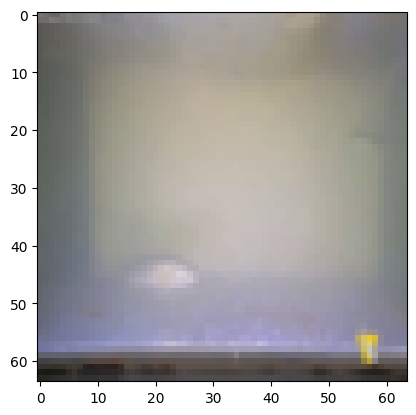

In [ ]:
img, label = dataset[1]
show_image(img, label)

Label: 1


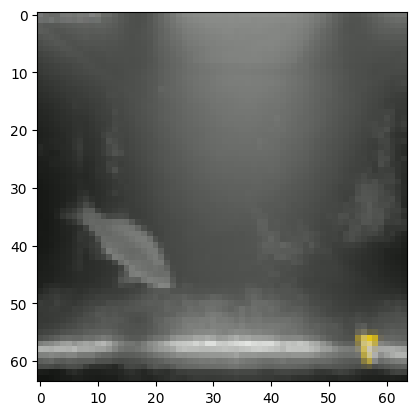

In [ ]:
img, label = dataset[500]
show_image(img, label)

Label: 3


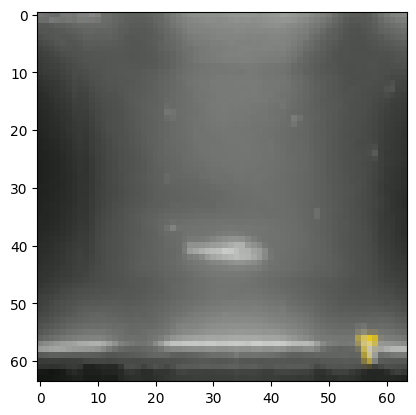

In [ ]:
img, label = dataset[3000]
show_image(img, label)



> **Dataset Split - train_ds, val_ds**



In [ ]:
random_seed = 1117
torch.manual_seed(random_seed)

train_ds, val_ds = random_split(dataset, [4400, 1164])   # train(80), test(20) 으로 dataset 나누어줌!
len(train_ds), len(val_ds)

(4400, 1164)

In [ ]:
# train_ds에 이미지 정보(픽셀별 RGB값이 어떻게 들어가 있는지 확인)

print(train_ds[0])            # train_ds에서 첫번째 이미지의 이미지정보와 레이블(0:cardboard)

print(train_ds[0][0])         # 첫번째 이미지의 이미지에서 레이블을 제외하고 이미지정보만 가져오기
print(len(train_ds[0][0][0])) # R값 > 64개의 픽셀
print(len(train_ds[0][0][1])) # G값 > 64개의 픽셀
print(len(train_ds[0][0][2])) # B값 > 64개의 픽셀

(tensor([[[0.4667, 0.4510, 0.4314,  ..., 0.5020, 0.5059, 0.5059],
         [0.4431, 0.4471, 0.4980,  ..., 0.4980, 0.5020, 0.4941],
         [0.3804, 0.3882, 0.4078,  ..., 0.5020, 0.4980, 0.4941],
         ...,
         [0.2353, 0.2431, 0.2431,  ..., 0.3373, 0.3294, 0.3216],
         [0.1412, 0.1255, 0.1255,  ..., 0.2392, 0.2667, 0.2431],
         [0.1725, 0.1765, 0.1882,  ..., 0.2157, 0.2039, 0.1843]],

        [[0.4863, 0.4588, 0.4275,  ..., 0.5176, 0.5216, 0.5216],
         [0.4627, 0.4549, 0.4941,  ..., 0.5137, 0.5137, 0.5059],
         [0.3804, 0.3882, 0.4000,  ..., 0.5176, 0.5137, 0.5059],
         ...,
         [0.2157, 0.2196, 0.2118,  ..., 0.3020, 0.3020, 0.2941],
         [0.1255, 0.1176, 0.1216,  ..., 0.1961, 0.2275, 0.2078],
         [0.1647, 0.1725, 0.1882,  ..., 0.2000, 0.1882, 0.1686]],

        [[0.4824, 0.4431, 0.4196,  ..., 0.5725, 0.5686, 0.5647],
         [0.4549, 0.4431, 0.4824,  ..., 0.5725, 0.5686, 0.5569],
         [0.3647, 0.3686, 0.3725,  ..., 0.5765, 0.5725, 0

In [ ]:
# To normalize the dataset, calculate the mean and std
## color image 이므로, RGB를 각각 나누어서 mean&std값 구함
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])

train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

In [ ]:
val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.5330966 0.5340984 0.52145106
0.53624225 0.5367547 0.5245944


In [ ]:
print(train_stdR, train_stdG, train_stdB)
print(val_stdR, val_stdG, val_stdB)

0.13033968 0.12831634 0.13839947
0.13028875 0.12783317 0.1375006


In [ ]:
# define the image transformation
train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

In [ ]:
# transformation을 dataset에 적용하고, dataloader를 생성
# apply transforamtion
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

# Layer Define

In [ ]:
!pip3 install utils

In [ ]:
from utils import *
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

In [ ]:
# convolutional operation 정의
## (3*3) operation
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## (1*1) operation
## 1x1 Convolution으로 채널 수를 줄인 상태에서 3x3 conv연산하기 위해서
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

## BasicBlock define
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)   # 3x3 stride = 2
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = 1
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
## Bottleneck define
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)       # conv1x1(64,64)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = conv3x3(planes, planes, stride) # conv3x3(64,64)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = conv1x1(planes, planes * self.expansion)  # conv1x1(64,256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)   # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# Model define

In [ ]:
# ResNet model define
class ResNet(nn.Module):
  #model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)       # resnet 50 => 여기서 resnet model 종류 선택!

  def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
      super(ResNet, self).__init__()

      self.inplanes = 64
      self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
      self.bn1 = nn.BatchNorm2d(64)
      self.relu = nn.ReLU(inplace=True)
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

      self.layer1 = self._make_layer(block, 64, layers[0])
      self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
      self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

      self.fc = nn.Linear(512 * block.expansion, num_classes)

      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          elif isinstance(m, nn.BatchNorm2d):
              nn.init.constant_(m.weight, 1)
              nn.init.constant_(m.bias, 0)

      if zero_init_residual:
          for m in self.modules():
              if isinstance(m, Bottleneck):
                  nn.init.constant_(m.bn3.weight, 0)
              elif isinstance(m, BasicBlock):
                  nn.init.constant_(m.bn2.weight, 0)


  def _make_layer(self, block, planes, blocks, stride=1):
      downsample = None
      if stride != 1 or self.inplanes != planes * block.expansion:

          downsample = nn.Sequential(
              conv1x1(self.inplanes, planes * block.expansion, stride), #conv1x1(256, 512, 2)
              nn.BatchNorm2d(planes * block.expansion), #batchnrom2d(512)
          )

      layers = []
      layers.append(block(self.inplanes, planes, stride, downsample))
      self.inplanes = planes * block.expansion #self.inplanes = 128 * 4

      for _ in range(1, blocks):
          layers.append(block(self.inplanes, planes)) # * 3

      return nn.Sequential(*layers)

  def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)

      x = self.layer1(x)
      x = self.layer2(x)
      x = self.layer3(x)
      x = self.layer4(x)
      x = self.avgpool(x)

      x = x.view(x.size(0), -1)
      x = self.fc(x)

      return x

In [ ]:
# 여러가지 ResNet model을 정의
def resnet18(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)  # => 2*(2+2+2+2) +1(conv1) +1(fc)  = 16 +2 =resnet 18
    return model

def resnet34(pretrained=False, **kwargs):
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    return model

def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)  # => 3*(3+4+6+3) +(conv1) +1(fc) = 48 +2 = 50
    return model

def resnet101(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    return model

def resnet152(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)  # 3*(3+8+36+3) +2 = 150+2 = resnet152
    return model



> **ResNet model 선택**



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet50().to(device)
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output.size())

torch.Size([3, 1000])


In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
device

device(type='cuda')

# Train

In [ ]:
######## loss function, optimizer, lr_scheduler #########
import torch.optim as optim
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

In [ ]:
# function to get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [ ]:
###### epoch, loss ########
# function to calculate loss and metric per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data
    return loss, metric

In [ ]:
import time

In [ ]:
# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}
    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss')

        lr_scheduler.step(val_loss)
        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':20,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}


# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/19, current lr=0.001
Get best val_loss
train loss: 1.343423, val loss: 1.180668, accuracy: 62.46, time: 1.2019 min
----------
Epoch 1/19, current lr=0.001
train loss: 1.033895, val loss: 1.337844, accuracy: 64.95, time: 2.3455 min
----------
Epoch 2/19, current lr=0.001
Get best val_loss
train loss: 0.944022, val loss: 0.976857, accuracy: 65.46, time: 3.4485 min
----------
Epoch 3/19, current lr=0.001
train loss: 0.815781, val loss: 1.239168, accuracy: 56.53, time: 4.5500 min
----------
Epoch 4/19, current lr=0.001
train loss: 0.822152, val loss: 1.418939, accuracy: 52.92, time: 5.6661 min
----------
Epoch 5/19, current lr=0.001
Get best val_loss
train loss: 1.107705, val loss: 0.937616, accuracy: 68.47, time: 6.8007 min
----------
Epoch 6/19, current lr=0.001
train loss: 0.836232, val loss: 1.113943, accuracy: 64.60, time: 7.9107 min
----------
Epoch 7/19, current lr=0.001
Get best val_loss
train loss: 0.729952, val loss: 0.688903, accuracy: 77.58, time: 9.0040 min
----------


# Result of training & test Prediction

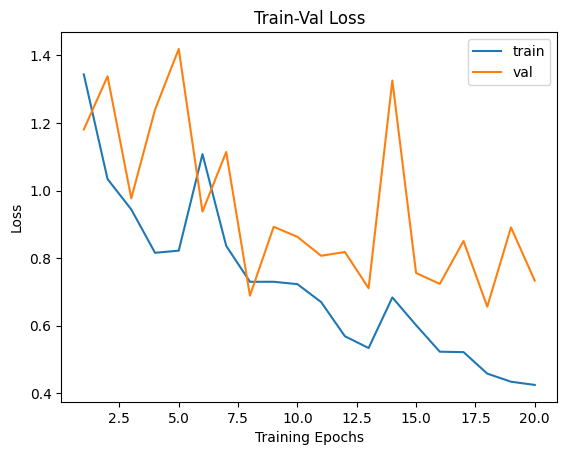

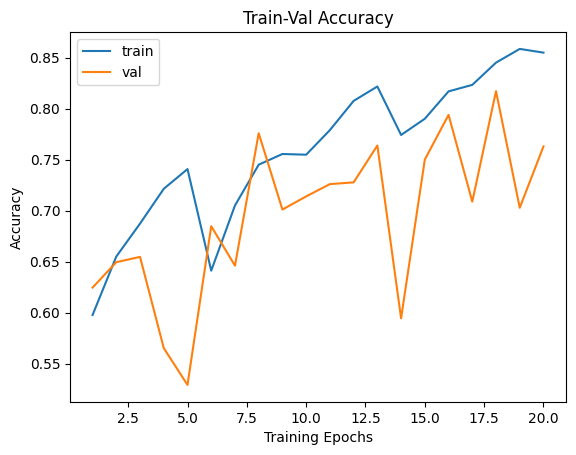

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [ ]:
model = model.to("cpu")

# test image prediction
def predict_image(img, model):
    xb = img.unsqueeze(0)                   # Convert to a batch of 1
    yb = model(xb)                          # Get predictions from model
    prob, preds  = torch.max(yb, dim=1)     # Pick index with highest probability
    return dataset.classes[preds[0].item()] # Retrieve the class label

Label: 3 , Predicted: 3


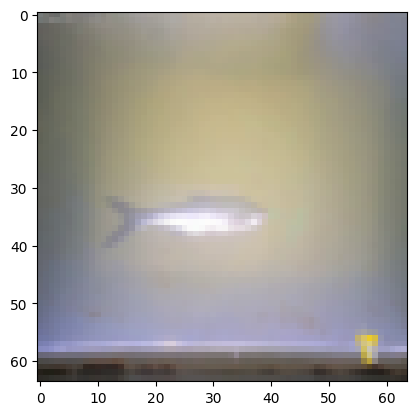

In [ ]:
img, label = train_ds[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


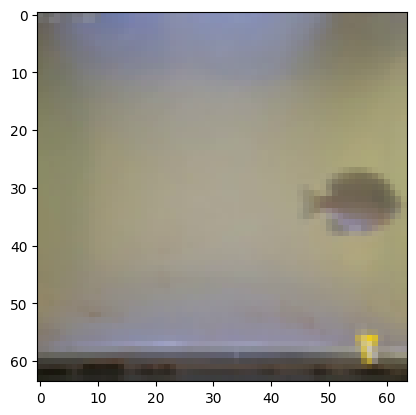

In [ ]:
img, label = train_ds[100]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


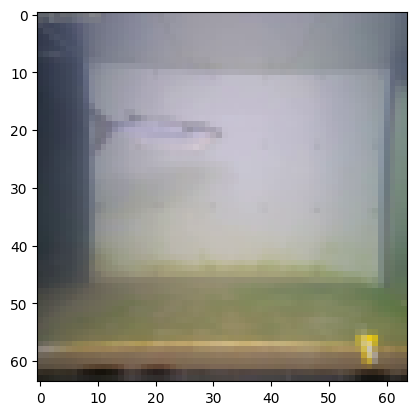

In [ ]:
img, label = train_ds[777]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
# save model
import pickle

#'resnet_model'은 저장할 파일의 이름이다.
with open('resnet_model', 'wb') as f:
    pickle.dump(model, f)

# Test data Prediction

In [ ]:
import matplotlib.pyplot as plt
import PIL

In [ ]:
preprocess = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [ ]:
def image_loader(path):
    image = PIL.Image.open(path)
    # 전처리 이후에 네트워크 입력에 들어갈 이미지에 배치 목적의 차원(dimension) 추가
    image = preprocess(image).unsqueeze(0)
    return image.to(device, torch.float) # GPU로 올리기

In [ ]:
path = '/content/MyDrive/MyDrive/test_0.png'
test_img = image_loader(path)
test_img

tensor([[[[0.3725, 0.3686, 0.3961,  ..., 0.3373, 0.3412, 0.3451],
          [0.3216, 0.3412, 0.4275,  ..., 0.3216, 0.3255, 0.3294],
          [0.2667, 0.2745, 0.2824,  ..., 0.3137, 0.3137, 0.3098],
          ...,
          [0.3373, 0.3451, 0.3451,  ..., 0.3922, 0.3922, 0.3843],
          [0.2000, 0.1882, 0.1843,  ..., 0.3216, 0.3255, 0.3137],
          [0.0863, 0.0863, 0.0941,  ..., 0.1294, 0.1451, 0.1137]],

         [[0.3804, 0.3765, 0.3961,  ..., 0.3451, 0.3490, 0.3529],
          [0.3294, 0.3490, 0.4353,  ..., 0.3294, 0.3333, 0.3373],
          [0.2745, 0.2824, 0.2941,  ..., 0.3216, 0.3216, 0.3176],
          ...,
          [0.3451, 0.3529, 0.3529,  ..., 0.4000, 0.4000, 0.3922],
          [0.2078, 0.1961, 0.1922,  ..., 0.3294, 0.3333, 0.3216],
          [0.0941, 0.0941, 0.1020,  ..., 0.1373, 0.1529, 0.1216]],

         [[0.3804, 0.3765, 0.3922,  ..., 0.3333, 0.3373, 0.3412],
          [0.3294, 0.3490, 0.4314,  ..., 0.3176, 0.3216, 0.3255],
          [0.2627, 0.2706, 0.2824,  ..., 0

In [ ]:
# torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
    # matplotlib는 CPU 기반이므로 CPU로 옮기기
    image = tensor.cpu().clone()
    # torch.Tensor에서 사용되는 배치 목적의 차원(dimension) 제거
    image = image.squeeze(0)
    # PIL 객체로 변경
    image = transforms.ToPILImage()(image)
    # 이미지를 화면에 출력(matplotlib는 [0, 1] 사이의 값이라고 해도 정상적으로 처리)
    plt.imshow(image)

In [ ]:
type(test_img)

torch.Tensor

In [ ]:
with open('resnet_model', 'rb') as f:
    resnet_model = pickle.load(f)

In [ ]:
# 기본적인 이미지를 실제 모델에 넣어 결과 확인
outputs = resnet_model(test_img)

In [ ]:
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
percentages

tensor([2.4864e-02, 1.7174e-02, 8.6188e+00, 9.1205e+01, 7.0590e-04, 3.1009e-02,
        9.4332e-02, 8.3991e-03, 5.6410e-09, 2.2554e-09, 3.4925e-09, 2.4684e-09,
        3.7146e-09, 4.9388e-09, 2.8238e-08, 2.9368e-10, 1.5425e-09, 9.3271e-10,
        5.3886e-09, 8.1318e-09, 2.9451e-09, 1.7166e-09, 4.7235e-09, 1.3843e-08,
        6.0574e-09, 1.1464e-08, 3.0391e-09, 4.4496e-10, 1.9829e-09, 1.0680e-08,
        8.4898e-09, 1.0158e-08, 5.2583e-09, 1.0926e-08, 1.5832e-09, 1.1369e-09,
        6.0365e-08, 6.2435e-09, 1.4358e-09, 2.8382e-09, 4.3314e-09, 1.0220e-08,
        9.5586e-09, 7.6900e-10, 1.0604e-08, 4.2673e-09, 1.6981e-08, 4.1520e-10,
        4.6142e-09, 2.9630e-09, 1.2792e-09, 1.7595e-08, 3.8233e-09, 1.6747e-09,
        3.5570e-09, 1.3794e-08, 3.9308e-09, 1.7543e-09, 3.2867e-09, 9.2464e-09,
        4.9514e-09, 1.1492e-09, 3.8946e-09, 3.4085e-09, 8.7906e-09, 7.7129e-10,
        1.4782e-08, 4.7625e-09, 1.2547e-09, 1.2082e-09, 5.7430e-09, 2.7166e-09,
        1.5582e-09, 3.5529e-09, 1.2736e-

In [ ]:
# 확률을 계산하기 위해 소프트맥스(softmax) 함수 취하기
percentages = torch.nn.functional.softmax(outputs, dim=1)[0] * 100

# 가장 높은 값을 가지는 5개의 인덱스를 하나씩 확인하며
print("< 가장 높은 확률을 가지는 클래스들 >")
for i in outputs[0].topk(5)[1]:
    # 높은 값을 가지는 순서대로 인덱스에 해당하는 클래스 이름과, 그 확률 값 출력하기
    print(f"인덱스: {i.item()} / 클래스명: {img_label[i]} / 확률: {round(percentages[i].item(), 4)}%")

< 가장 높은 확률을 가지는 클래스들 >


NameError: ignored